In [21]:
import os
import itertools
import glob
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tqdm as tqdm
import matplotlib as mpl
import matplotlib.ticker
import matplotlib.pyplot as plt
import zipfile
import PIL.Image

sns.set(font_scale=0.9, style='whitegrid', font='CMU Sans Serif')
pal = sns.color_palette(['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB'])
sns.set_palette(pal)

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.figsize'] = (4.5,2)
mpl.rcParams['figure.dpi'] = 100

In [22]:
IMAGE_LOG = "../pkg/model/image_log_with_alt.csv"
IMAGES = "../pkg/model/images"

BCY_TAU = 0.2

BAND_INDICES = {
    "B01": 0,
    "B02": 1,
    "B03": 2,
    "B04": 3,
    "B05": 4,
    "B06": 5,
    "B07": 6,
    "B08": 7,
    "B8A": 8,
    "B09": 9,
    "B11": 10,
    "B12": 11,
    "CLD": 12,
}

SAMPLE = 0.3

RANDOM_SEED = 42

In [23]:
rng = np.random.default_rng(RANDOM_SEED)

In [24]:
# read the image log to find out what images exist
image_ids = []
with open(IMAGE_LOG, 'r') as f:
    for line in f:
        t_ms, lat, lon, alt, is_sunlit = line.strip().split(',')
        if not is_sunlit == "1":
            continue

        image_ids.append(t_ms)

In [25]:
# based on the Braaten-Cohen-Yang cloud detection algorithm
# https://custom-scripts.sentinel-hub.com/sentinel-2/cby_cloud_detection/
#
# B11 > tau (tau may be 0.2) AND ((B03 > 0.175 AND	NDGR > 0) OR B03 > 0.39)
# NGDR = (B03 - B04) / (B03 + B04)
def bcy_cloud_percentage(image):
    # def _bcy_cloud_px(px):
    #     b11 = px[BAND_INDICES["B11"]]
    #     b03 = px[BAND_INDICES["B03"]]
    #     b04 = px[BAND_INDICES["B04"]]
    #     return b11 > BCY_TAU and (b03 > 0.39 or (b03 > 0.175 and (b03 - b04) / (b03 + b04) > 0))

    # return np.sum(np.apply_along_axis(_bcy_cloud_px, 2, image)) / image.size

    return np.sum(
        (image[:, :, BAND_INDICES["B11"]] > (BCY_TAU*255)) &
        (
            (image[:, :, BAND_INDICES["B03"]] > 0.39) |
            (
                (image[:, :, BAND_INDICES["B03"]] > 0.175) &
                ((image[:, :, BAND_INDICES["B03"]] - image[:, :, BAND_INDICES["B04"]]) /
                 (image[:, :, BAND_INDICES["B03"]] + image[:, :, BAND_INDICES["B04"]]) > 0)
            )
        )
    ).astype(np.float32) / (image.shape[0] * image.shape[1])

In [26]:
# the CLD band is our baseline
def cld_cloud_percentage(image):
    # don't ask why, but there are some images where a CLD pixel is above 100
    return np.sum(np.clip(image[:, :, BAND_INDICES["CLD"]], 0, 100)) / 100 / (image.shape[0] * image.shape[1])

In [27]:
def read_image(image_path, lam):
    # basically a zip file of a bunch of tiffs
    # ..._B01.tiff, ..._B02.tiff, etc.

    bands = []
    # print(image_path)
    with zipfile.ZipFile(image_path) as zf:
        # print(f"Reading {os.path.basename(image_path)}")
        for band in BAND_INDICES.keys():
            with zf.open(f"{os.path.basename(image_path)[:-4]}_{band}.tiff") as f:
                bands.append(np.array(PIL.Image.open(f)))

    return lam(os.path.basename(image_path)[:-4], np.stack([band for band in bands], axis=2))

images = [os.path.join(IMAGES, f"{i}.zip") for i in image_ids]

data = (
    read_image(f, lambda n, x: (n, bcy_cloud_percentage(x), cld_cloud_percentage(x)))
    for f in rng.choice(images, int(len(images) * SAMPLE), replace=False)
)

df = pd.DataFrame(tqdm.tqdm(data), columns=["name", "bcy", "cld"])

0it [00:00, ?it/s]/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_36116/2976648366.py:21: RuntimeWarning: divide by zero encountered in divide
  ((image[:, :, BAND_INDICES["B03"]] - image[:, :, BAND_INDICES["B04"]]) /
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_36116/2976648366.py:21: RuntimeWarning: invalid value encountered in divide
  ((image[:, :, BAND_INDICES["B03"]] - image[:, :, BAND_INDICES["B04"]]) /
6494it [00:24, 268.62it/s]


In [28]:
df.head()

,name,bcy,cld
0,4970800,1.0,1.000000
1,16350400,0.0,0.499265
2,6248400,0.0,0.000000
3,11435200,0.0,0.000157
4,696000,1.0,0.500000


In [31]:
df_stacked = df.melt(id_vars=["name"], value_vars=["bcy", "cld"], var_name="method", value_name="cloud_percentage")

/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_36116/661529409.py:1: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.ecdfplot(data=df_stacked, x="cloud_percentage", hue="method", palette=pal)


<Axes: xlabel='cloud_percentage', ylabel='Proportion'>

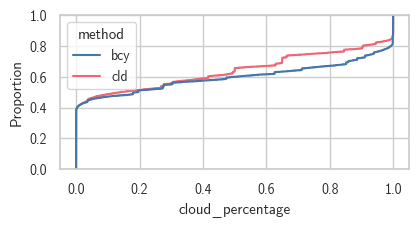

In [32]:
sns.ecdfplot(data=df_stacked, x="cloud_percentage", hue="method", palette=pal)

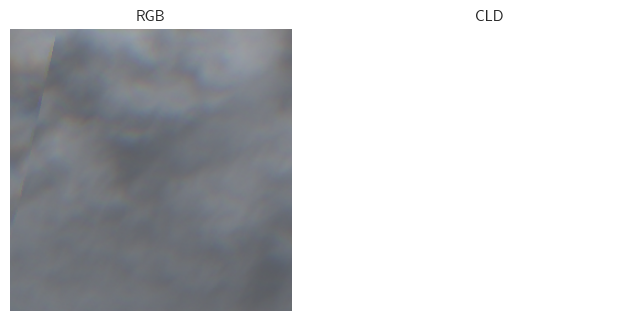

BCY: 0.62
CLD: 1.00


/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_74738/2976648366.py:21: RuntimeWarning: divide by zero encountered in divide
  ((image[:, :, BAND_INDICES["B03"]] - image[:, :, BAND_INDICES["B04"]]) /
/var/folders/2f/b2y6thfs2051_m0fs57vb_sc0000gn/T/ipykernel_74738/2976648366.py:21: RuntimeWarning: invalid value encountered in divide
  ((image[:, :, BAND_INDICES["B03"]] - image[:, :, BAND_INDICES["B04"]]) /


In [134]:
test_image = "../pkg/model/images/0.zip"

image = read_image(test_image, lambda n, x: x)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(image[:, :, (BAND_INDICES["B04"], BAND_INDICES["B03"], BAND_INDICES["B02"])] / 255, vmin=0.0, vmax=1.0)
ax[0].set_title("RGB")
ax[0].axis("off")

ax[1].imshow(image[:, :, BAND_INDICES["CLD"]] / 100, vmin=0.0, vmax=1.0, cmap="gray")
ax[1].set_title("CLD")
ax[1].axis("off")

plt.show()

print(f"BCY: {bcy_cloud_percentage(image):.2f}")
print(f"CLD: {cld_cloud_percentage(image):.2f}")

In [135]:
image[:, :, BAND_INDICES["B11"]].max()

105

(-0.5, 255.5, 255.5, -0.5)

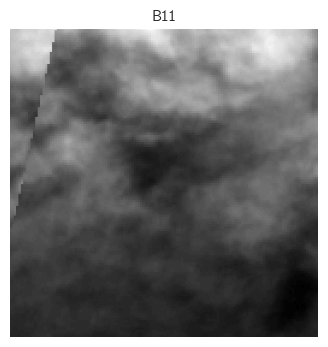

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.imshow(image[:, :, BAND_INDICES["B11"]], cmap="gray")
ax.set_title("B11")
ax.axis("off")


In [18]:
# what is the max cld image?
max_cld = df.loc[df["cld"].idxmax()]
print(max_cld)

name    11638800
bcy          1.0
cld          1.0
Name: 30, dtype: object


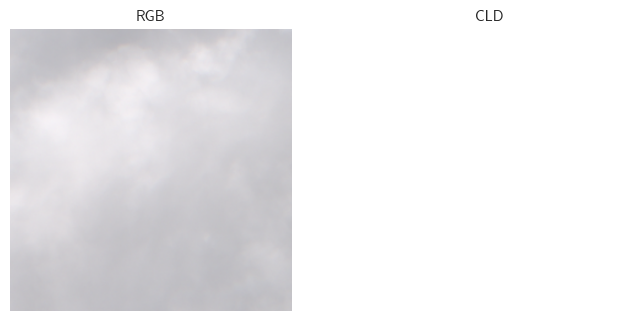

BCY: 1.00
CLD: 1.85


In [142]:
cld_test_image = "../pkg/model/images/15498400.zip"

cld_image = read_image(cld_test_image, lambda n, x: x)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(cld_image[:, :, (BAND_INDICES["B04"], BAND_INDICES["B03"], BAND_INDICES["B02"])] / 255, vmin=0.0, vmax=1.0)
ax[0].set_title("RGB")
ax[0].axis("off")

ax[1].imshow(cld_image[:, :, BAND_INDICES["CLD"]] / 100, vmin=0.0, vmax=1.0, cmap="gray")
ax[1].set_title("CLD")
ax[1].axis("off")

plt.show()

print(f"BCY: {bcy_cloud_percentage(cld_image):.2f}")
print(f"CLD: {cld_cloud_percentage(cld_image):.2f}")

In [144]:
cld_image[:, :, BAND_INDICES["CLD"]].max()

214

In [41]:
# calculate some error rates
threshold = 0.3
df["bcy_cloud"] = df["bcy"] > threshold
df["cld_cloud"] = df["cld"] > threshold

# true positive
tp = np.sum(df["bcy_cloud"] & df["cld_cloud"])

# false positive
fp = np.sum(df["bcy_cloud"] & ~df["cld_cloud"])

# false negative
fn = np.sum(~df["bcy_cloud"] & df["cld_cloud"])

# true negative
tn = np.sum(~df["bcy_cloud"] & ~df["cld_cloud"])

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

print(f"True positive: {tp}")
print(f"False positive: {fp}")
print(f"False negative: {fn}")
print(f"True negative: {tn}")

Precision: 0.78
Recall: 0.79
F1: 0.78
True positive: 2261
False positive: 651
False negative: 615
True negative: 2967
